# SEPP Estimation test bed

An attempt to replicate the appendix of Mohler et al.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp.sepp as sepp
import open_cp.sources.sepp as seppsim
import open_cp
import open_cp.kernels

In [3]:
region = open_cp.RectangularRegion(-50, 50, -50, 50)
background_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.HomogeneousPoisson(rate=5.71),
    seppsim.GaussianSpaceSampler([0,0], [4.5**2, 4.5**2], 0))
total_rate = 0.2
trigger_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.Exponential(exp_rate=0.1, total_rate=total_rate),
    seppsim.GaussianSpaceSampler([0,0], [0.01**2, 0.1**2], 0))
sampler = seppsim.SelfExcitingPointProcess(region, background_sampler, trigger_sampler)

## Background events

These are a constant rate marked Poisson process, with the "marks" (the space coordinates) normally distributed.  It is not clear to me why Mohler et al. chose 5.71 as the Poisson rate!

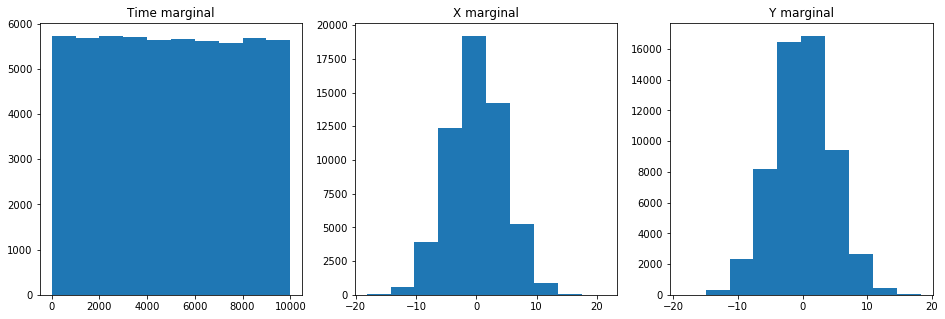

In [4]:
backs = background_sampler.sample(0, 10000)
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
for i, t in enumerate(["Time", "X", "Y"]):
    ax[i].hist(backs[i])
    ax[i].set_title(t + " marginal")

## Triggered events

I believe there is a **mis-print in the paper** here.  They display the formula

$$ g(t,x,y) = \theta \omega \exp(-\omega t) \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big)\exp\Big(-\frac{y^2}{2\sigma_y^2}\Big) $$
with parameters $\sigma_x=0.01, \sigma_y=0.1, \theta=0.2, \omega^{-1}=10$.  However, in Figure A.2. they show the time marginal (i.e. integrate out $x$ and $y$ which is an exponential decay with value $0.02 = \theta\omega$ at $t=0$.

Thus, I believe that the normalisation of the Gaussian is missing, and we should have
$$ g(t,x,y) = \frac{\theta}{2\pi\sigma_x\sigma_y} \omega \exp(-\omega t) \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big)\exp\Big(-\frac{y^2}{2\sigma_y^2}\Big) $$
The marginals for $x$ and $y$ also agree with this.

In [5]:
trigs = []
for _ in range(50000):
    x = trigger_sampler.sample(0, 100)
    for coord in x.T:
        trigs.append(coord)
trigs = np.asarray(trigs).T
trigs.shape

(3, 10144)

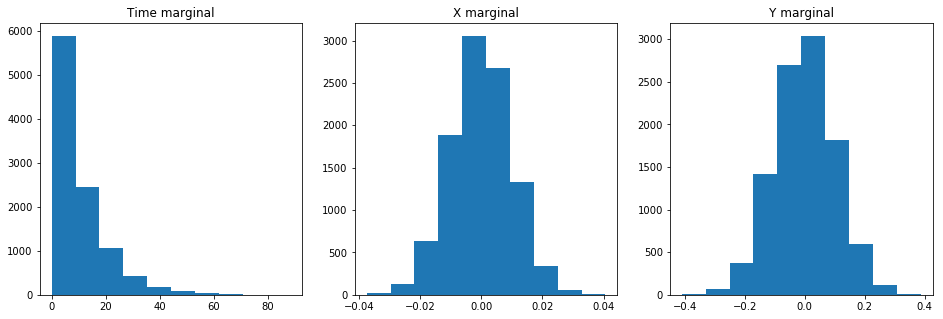

In [6]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
for i, t in enumerate(["Time", "X", "Y"]):
    ax[i].hist(trigs[i])
    ax[i].set_title(t + " marginal")

In [7]:
pts = sampler.sample(0,500)
pts = pts[:, 2000:]
pts.shape

(3, 1468)

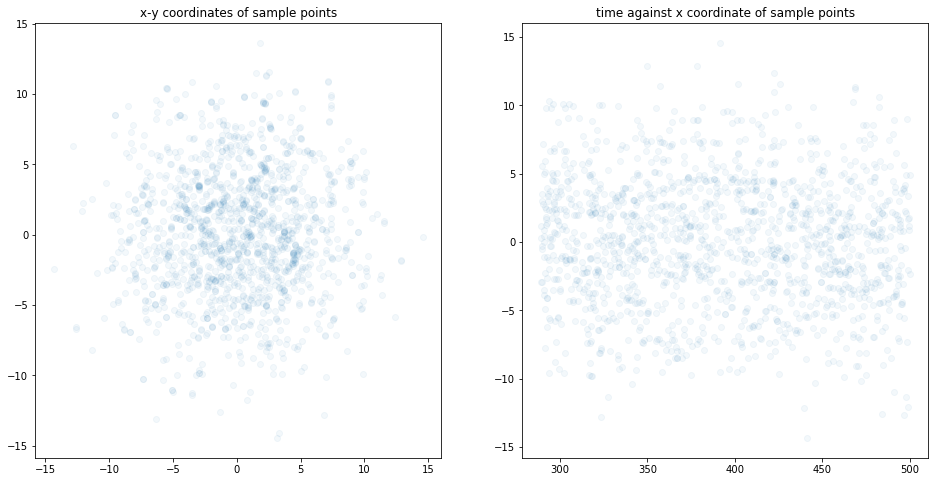

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))
ax[0].scatter(pts[1], pts[2], alpha=0.05)
ax[0].set_title("x-y coordinates of sample points")
ax[1].scatter(pts[0], pts[1], alpha=0.05)
ax[1].set_title("time against x coordinate of sample points")
None

## Using the real distributions

If we use the actual kernels the data was sampled from, then we find that most events are classified as "background".

In [16]:
def actual_background_kernel(pts):
    norm = 2 * 4.5 * 4.5
    return 5.71 * np.exp(- (pts[1]**2 + pts[2]**2) / norm) / (norm * np.pi)

def actual_trigger_kernel(pts):
    sigma_x = 0.01
    sigma_y = 0.1
    theta = 0.2
    omega = 1 / 10
    return ( theta * omega * np.exp(-omega * pts[0]) *
        np.exp(-pts[1]**2 / (2 * sigma_x**2)) * np.exp(-pts[2]**2 / (2 * sigma_y**2))
        / (2 * np.pi * sigma_x * sigma_y) )

In [17]:
decluster = sepp.StocasticDecluster()
decluster.points = pts
decluster.background_kernel_estimator = open_cp.kernels.KthNearestNeighbourGaussianKDE()
decluster.trigger_kernel_estimator = open_cp.kernels.KthNearestNeighbourGaussianKDE()

p = sepp.p_matrix(pts, actual_background_kernel, actual_trigger_kernel)
backs, trigs = sepp.sample_points(pts, p)
backs.shape, trigs.shape

((3, 1193), (3, 275))

Let us look at what the KDE returns for the background rate.  The real distribution is Gaussian (standard deviation 4.5) in space, and constant with rate $\mu = 5.71$ in space.  We have data points in the time range about [250:500] so we expect moderately poor behaviour near the edges due to edge effects (and the fact that at this stage, we're not using a KDE which is well suited to the "factorised" nature of the background density $\nu(t) \mu(x,y)$).

The peak of the Gaussian, with one variable integrated out, should be $\mu / \sqrt{2\pi \times 4.5} \approx 0.51$

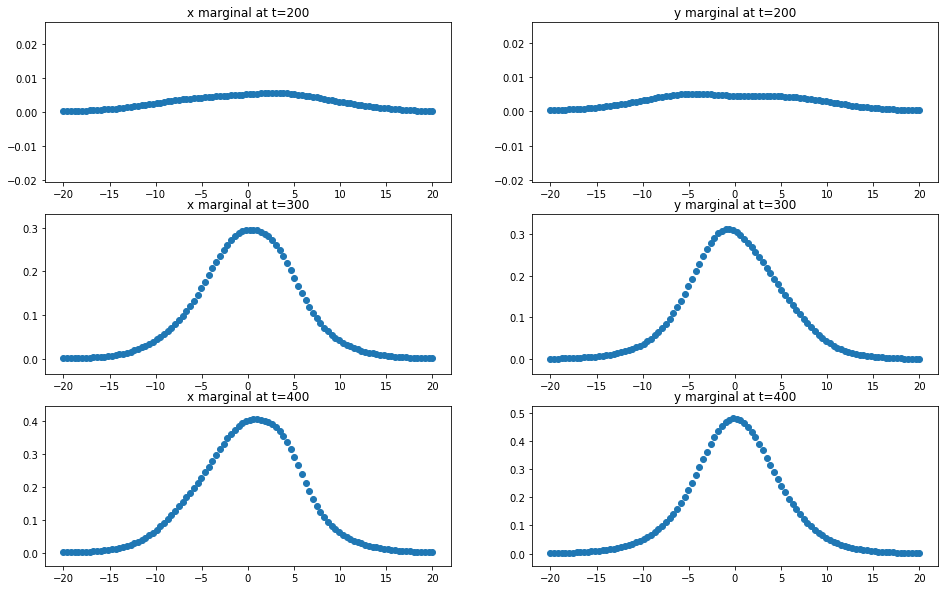

In [18]:
import scipy.integrate

bk = decluster.background_kernel_estimator(backs)
bkernel = lambda pt : bk(pt) * backs.shape[-1]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,10))

for row, t in enumerate([200, 300, 400]):
    def y_marginal(y):
        return scipy.integrate.quad(lambda x : bkernel([t,x,y]), -30, 30)[0]
    def x_marginal(x):
        return scipy.integrate.quad(lambda y : bkernel([t,x,y]), -30, 30)[0]
    x = np.linspace(-20, 20, 100)
    xprob = [ x_marginal(xx) for xx in x ]
    ax[row][0].scatter(x, xprob)
    ax[row][0].set_title("x marginal at t={}".format(t))
    xprob = [ y_marginal(xx) for xx in x ]
    ax[row][1].scatter(x, xprob)
    ax[row][1].set_title("y marginal at t={}".format(t))

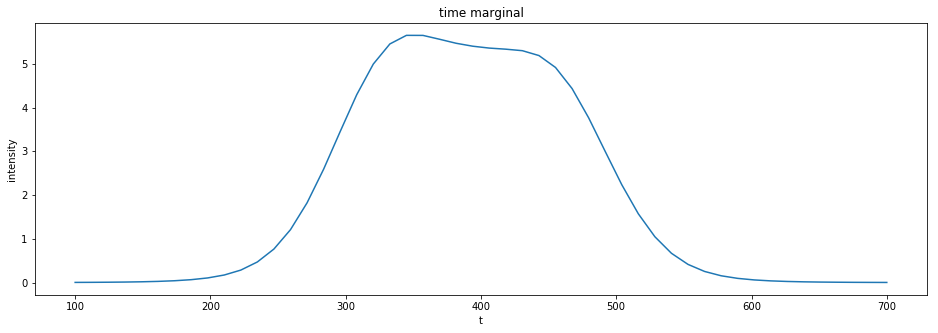

In [19]:
def tx_marginal(t, x):
    return scipy.integrate.quad(lambda y : bkernel([t,x,y]), -30, 30)[0]
def t_marginal(t):
    return scipy.integrate.quad(lambda x : tx_marginal(t, x), -30, 30)[0]

t = np.linspace(100,700,50)
tprob = [ t_marginal(tt) for tt in t ]
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(t, tprob)
ax.set_title("time marginal")
ax.set_xlabel("t")
ax.set_ylabel("intensity")
None

## With a better estimator

We try this again, but now following Mohler et al. more closely, and estimating $\nu$ and $\mu$ separately, using $k=100$ nearest neighbour distance for $\nu$ and $k=15$ nearest neighbour distance for $\mu$.

In [30]:
KDE = open_cp.kernels.KNNG1_NDFactors(100, 15)
bk = KDE(backs)

In [31]:
first = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(backs[0], 100)
rest = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(backs[1:], 15)

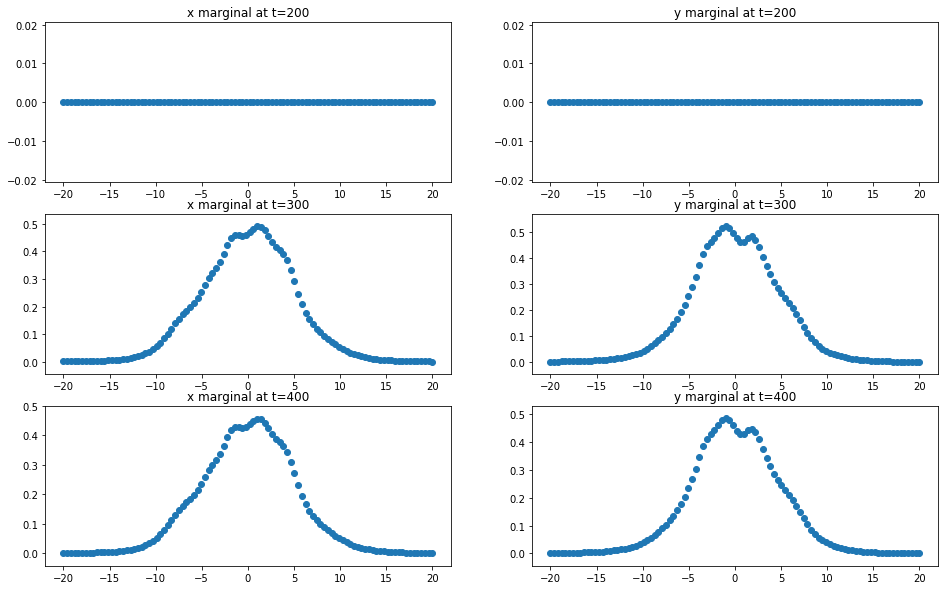

In [34]:
bkernel = lambda pt : bk(pt) * backs.shape[-1]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,10))

for row, t in enumerate([200, 300, 400]):
    def y_marginal(y):
        return scipy.integrate.quad(lambda x : bkernel([t,x,y]), -30, 30)[0]
    def x_marginal(x):
        return scipy.integrate.quad(lambda y : bkernel([t,x,y]), -30, 30)[0]
    x = np.linspace(-20, 20, 100)
    xprob = [ x_marginal(xx) for xx in x ]
    ax[row][0].scatter(x, xprob)
    ax[row][0].set_title("x marginal at t={}".format(t))
    xprob = [ y_marginal(xx) for xx in x ]
    ax[row][1].scatter(x, xprob)
    ax[row][1].set_title("y marginal at t={}".format(t))

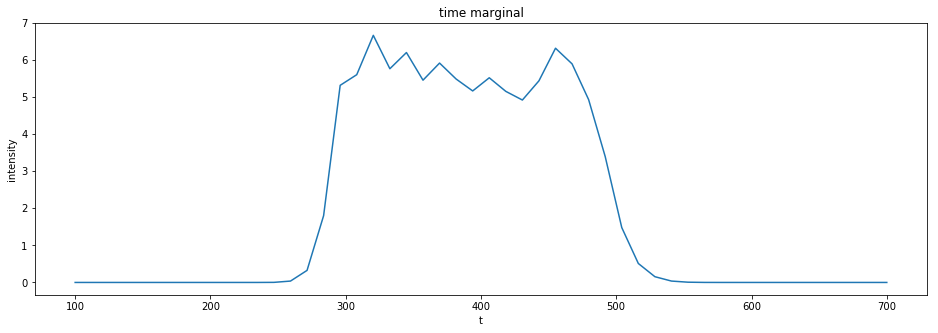

In [35]:
def tx_marginal(t, x):
    return scipy.integrate.quad(lambda y : bkernel([t,x,y]), -30, 30)[0]
def t_marginal(t):
    return scipy.integrate.quad(lambda x : tx_marginal(t, x), -30, 30)[0]

t = np.linspace(100,700,50)
tprob = [ t_marginal(tt) for tt in t ]
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(t, tprob)
ax.set_title("time marginal")
ax.set_xlabel("t")
ax.set_ylabel("intensity")
None

This is still a bit noisy, but it looks, visually, better than the other estimate.

## Triggered events kernel estimation

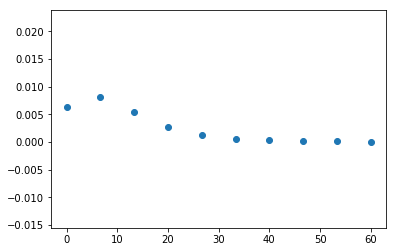

In [58]:
tk = decluster.trigger_kernel_estimator(trigs)
tkernel = lambda points : tk(points) * trigs.shape[-1] / pts.shape[-1]

def tx_marginal(t, x):
    return scipy.integrate.quad(lambda y : tkernel([t,x,y]), -10, 10)[0]
def ty_marginal(t, y):
    return scipy.integrate.quad(lambda x : tkernel([t,x,y]), -10, 10)[0]
def t_marginal(t):
    return scipy.integrate.quad(lambda x : tx_marginal(t, x), -10, 10)[0]

t = np.linspace(0, 60, 10)
tprob = [t_marginal(tt) for tt in t]
plt.scatter(t, tprob)

## Optimising

To start the optimisation, we need to provide reasonable "bandwidths" for the data.  The `StocasticDecluster` class comes with parameters suitable for real data, so we need to override them.